In [ ]:
# Exercise 1 (Lab 4)

# To acheive the largest response, set lab.P1 = 255 for all subsequent experiments. 
# You will use heater Q2 to introduce disturbances, so you can set lab.P2 = 50 for all experiments.

# Choose a sample time 2 seconds or longer for all subsequent experiments.

# Perform a step test measuring the response of temperature T2 to a step change in heater input Q1. 
# The step input in Q1 should be limited to no more than 50% to avoid potential melting of the thermal paste in heater 1


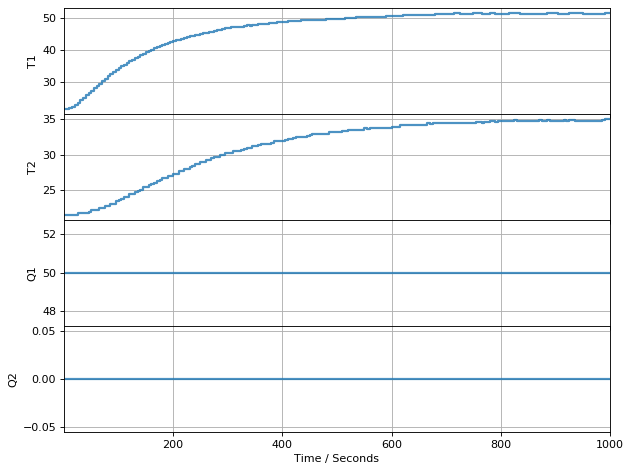

TCLab disconnected successfully.


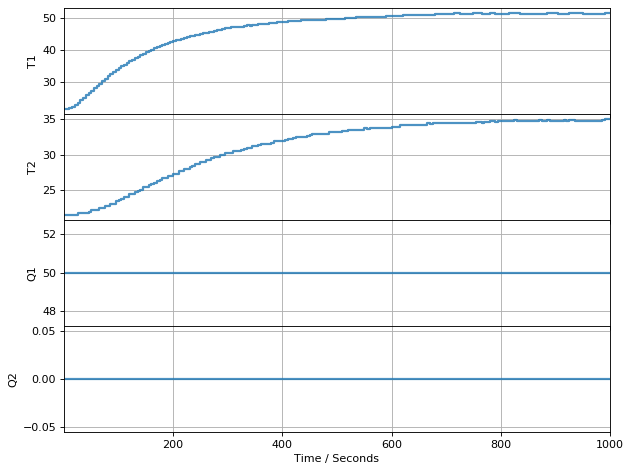

In [62]:
# STEP TEST
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

t_final = 1000  
t_step = 5

TCLab = setup(connected=True)
with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # set heaters
        lab.P1 = 255
        lab.P2 = 50

        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            T2 = lab.T2
            lab.U1 = 50 
        
            p.update(t)  
h.to_csv('lab4_ex1_step_test.csv')

In [63]:
# From the step test, fit a first order plus dead time (FOPDT) model (to T2). 
# Report the parameters  𝐾  (steady-state gain),  𝑇  (time constant), and  𝜏  (time delay). 
# Present a plot comparing your model fit to the measured data.

In [64]:
# Read data into panda dataframe

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

# read data file from the Github repository into a Pandas dataframe
data_location = "lab4_ex1_step_test.csv"
expt = pd.read_csv(data_location)

# set time index
expt = expt.set_index("Time")
t_expt = expt.index

# display data in tabular format
display(expt)


,T1,T2,Q1,Q2
Time,,,,
0.00,21.769,21.543,50.0,0.0
5.00,21.865,21.575,50.0,0.0
10.00,22.026,21.575,50.0,0.0
15.00,22.510,21.607,50.0,0.0
20.02,22.993,21.543,50.0,0.0
...,...,...,...,...
980.01,51.191,34.756,50.0,0.0
985.01,51.191,34.853,50.0,0.0
990.00,51.514,34.949,50.0,0.0


In [65]:
# create a function to compare two data sets
def plot_data(expt, pred):
    t_expt = expt.index
    
    # create a 3 x 1 grid of plot axes
    fig, ax = plt.subplots(3, 1, figsize=(10,8))
    
    # first plot axes
    ax[0].scatter(t_expt, expt["T1"], label="T1 expt")
    ax[0].scatter(t_expt, expt["T2"], label="T2 expt")
    ax[0].plot(t_expt, pred["T1"], label="T1 pred")
    ax[0].plot(t_expt, pred["T2"], label="T2 pred")
    ax[0].set_ylabel("deg. C.")
    ax[0].set_title("Temperature Response")

    # second plot axes
    ax[1].scatter(t_expt, expt["Q1"], label="Q1 expt")
    ax[1].scatter(t_expt, expt["Q2"], label="Q2 expt")
    ax[1].plot(t_expt, pred["Q1"], label="Q1 pred")
    ax[1].plot(t_expt, pred["Q2"], label="Q2 pred")
    ax[1].set_ylim([0, 100])
    ax[1].set_ylabel("Percent")
    ax[1].set_title("Heater Power")
    
    # third plot axes
    ax[2].plot(t_expt, pred["T1"]-expt["T1"], label="T1 error")
    ax[2].plot(t_expt, pred["T2"]-expt["T2"], label="T1 error")
    ax[2].set_title("Residuals")
    
    # things to do for every plot axes
    for a in ax:
        a.grid(True)
        a.set_xlabel("time / seconds")
        a.legend()
        
    plt.tight_layout()
    
    return


Time
0.00      -0.543000
5.00      -0.575000
10.00     -0.575000
15.00     -0.607000
20.02     -0.543000
             ...   
980.01     0.888371
985.01     0.798439
990.00     0.709353
995.00     0.651143
1000.01    0.690811
Name: T2, Length: 201, dtype: float64

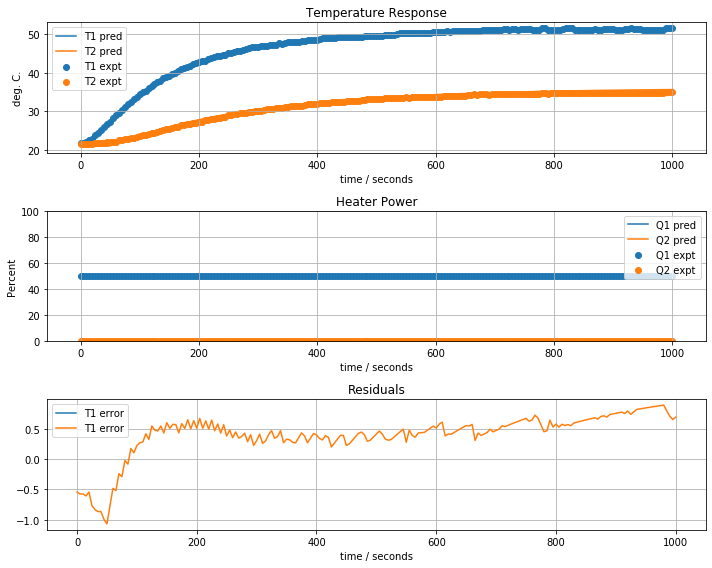

In [68]:
# FIRST ORDER PLUS DEAD TIME (FOPDT)

# parameter values and units
T_amb = 21                 # deg C
u1bar = expt["Q1"].mean()
t_expt = expt.index

# adjustable parameters
K = 0.3
time_cst = 250
t_delay = 48

def model_first_order_delay(param, plot=False):
    K, tau, t_delay = param
    pred = pd.DataFrame(columns=["T1", "T2", "Q1", "Q2"], index=t_expt)
    pred["T2"] = [T_amb + K*u1bar*(1 - np.exp(-(t-t_delay)/tau)) if t > t_delay else T_amb for t in t_expt]
    if plot:
        plot_data(expt, pred)
    return pred["T2"] - expt["T2"]
    
model_first_order_delay([K, tau, t_delay], True)

K = 0.28752432901093417,  tau = 249.07275064052465, time delay = 47.77313771389722


Time
0.00      -0.543000
5.00      -0.575000
10.00     -0.575000
15.00     -0.607000
20.02     -0.543000
             ...   
980.01     0.279687
985.01     0.189455
990.00     0.100075
995.00     0.041577
1000.01    0.080962
Name: T2, Length: 201, dtype: float64

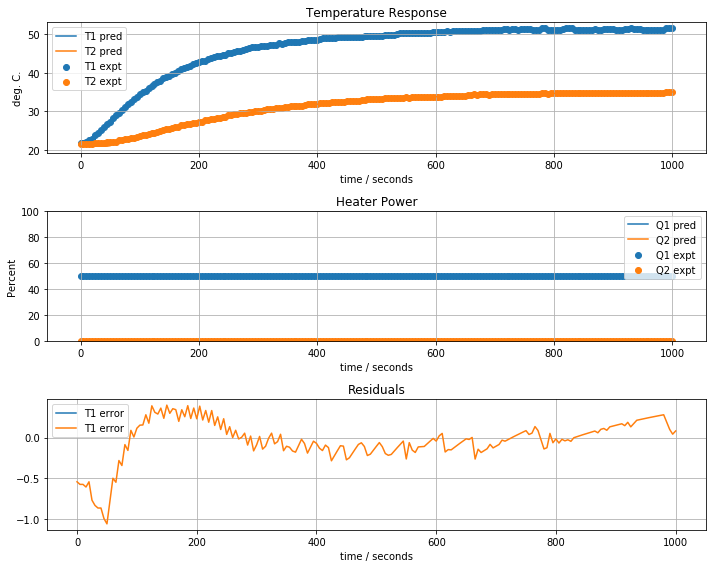

In [67]:
# Use least squares fit
results = least_squares(model_first_order_delay,  [K, tau, t_delay])
K, tau, t_delay = results.x
print(f"K = {K},  tau = {tau}, time delay = {t_delay}")
model_first_order_delay(results.x, True)

In [70]:
# Report the parameters  𝐾  (steady-state gain),  𝑇  (time constant), and  𝜏  (time delay).
# Values found using least-squares regression model fitting 

K_lsf = 0.2875
time_cst_lsf = 249.1
t_delay_lsf = 47.773

print('The steady-state gain is',K_lsf,'deg. C./% max. power.')
print('The time constant is',time_cst_lsf,'seconds.')
print('The time delay is',t_delay_lsf,'seconds.')

The steady-state gain is 0.2875 deg. C./% max. power.
The time constant is 249.1 seconds.
The time delay is 47.773 seconds.


In [71]:
# Use the Astrom and Murray tuning rules (see Notebook 3.5) to estimate values for the PI control parameters  𝐾𝑃  and  𝐾𝐼 .

Kp_val = (0.15*t_delay_lsf+0.35*time_cst_lsf)/(K_lsf*t_delay_lsf)
print('The estimated value for proportional gain, Kp, is:',round(Kp_val,3))

# proportional gain may be a bit high

Ki_val = (0.46*t_delay_lsf+0.02*time_cst_lsf)/(K_lsf*t_delay_lsf**2)
print('The estimated value for integral gain, Ki, is:',round(Ki_val,3))

# integral gain may be a bit low


The estimated value for proportional gain, Kp, is: 6.87
The estimated value for integral gain, Ki, is: 0.041


In [ ]:
# Implement an antiwindup version of PI control using the parameter values determined above. 
# Test the performance of the controller in acheiving a setpoint of 30 deg C for temperature T2, 
# and maintaining the setpoint following a disturbance where Q2 is set to 20% at t = 300 seconds.

In [74]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

# create a function that introduces the setpoint and the disturbance
def experiment(controller, t_final=1000, t_step=5,
               SP=lambda t: 30 if t >= 20 else 0, 
               DV=lambda t: 20 if t >= 300 else 0):


    TCLab = setup(connected=True)
    with TCLab() as lab:

        # set up historian and plotter
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variables
        lab.P1 = 255
        lab.P2 = 50
        next(controller)

        # event loop
        for t in clock(t_final, t_step):
            T2 = lab.T2
            U1 = lab.Q1()                            # <==== new line
            U1 = controller.send((t_step, SP(t), T2, U1))    # <==== send U1 to controller 
            lab.Q1(U1)
            lab.Q2(DV(t)) # <==== disturbance
            p.update(t)  
            
    h.to_csv('lab4_exercise1.csv')

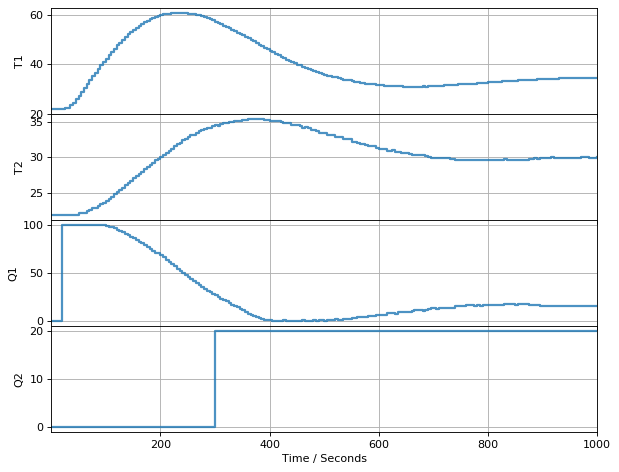

TCLab disconnected successfully.


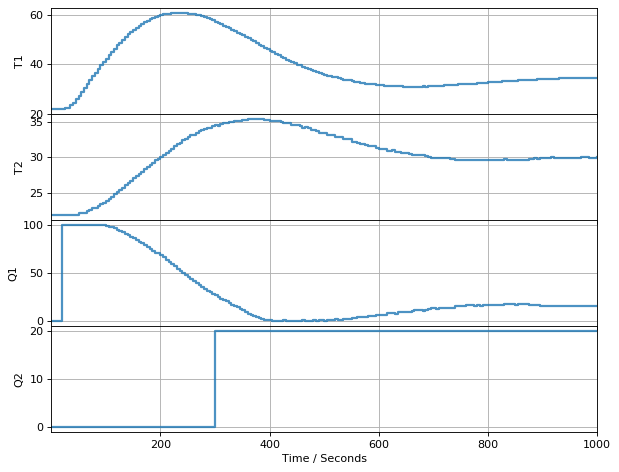

In [75]:
def PI_antiwindup(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    while True:
        t_step, SP, PV, MV = yield MV   # <==== now gets MV from experiment
        e = PV - SP
        MV += -Kp*(e - e_prev) - t_step*Ki*e 
        MV = max(MV_min, min(MV_max, MV))
        e_prev = e
        
controller = PI_antiwindup(Kp_val, Ki_val, MV_bar=0, MV_min=0, MV_max=100)
experiment(controller)
